In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import os
import requests

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [21]:
# Download Tiny Shakespeare dataset
def download_dataset():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    response = requests.get(url)
    with open('tiny_shakespeare.txt', 'w') as f:
        f.write(response.text)
    return response.text

# Load data
text = download_dataset()
print(f"Dataset size: {len(text)} characters")
print(f"First 200 characters:\n{text[:200]}")

Dataset size: 1115394 characters
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


Text is successfully loaded into the file and top 200 chars are viewed.

In [22]:
#tokenization strategies employed below

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import torch


# Initialize empty tokenizer ( BPE )
tokenizer = Tokenizer(BPE())

# Pre-tokenization (splits on whitespace first)
tokenizer.pre_tokenizer = Whitespace()

# Trainer: vocab size can be tuned (configured as 500 here)

# [PAD]	Padding	Make all sequences same length
# [UNK]	Unknown token	Replace out-of-vocab words
# [BOS]	Beginning of sentence	Sequence start marker
# [EOS]	End of sentence	Sequence end marker
trainer = BpeTrainer(vocab_size=500, special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"])

# Train the tokenizer on your dataset (text) here
tokenizer.train_from_iterator([text], trainer=trainer)

# Get vocabulary size and till 50 tokens
vocab_size = tokenizer.get_vocab_size()
chars = list(tokenizer.get_vocab().keys())
print(f"Vocabulary size: {vocab_size}")
print(f"Tokens: {chars[:50]} ...")

# Create mappings (token to id and id to token) bidirectional !!
char_to_idx = tokenizer.get_vocab()
idx_to_char = {v: k for k, v in char_to_idx.items()}


# Encode (string to tensor of token IDs) - output is a torch tensor of token ids
def encode(text):
    ids = tokenizer.encode(text).ids
    return torch.tensor(ids, dtype=torch.long)

# Decode (list of ids to string) - gets the string output from tensor values given as indices
def decode(indices):
    return tokenizer.decode(indices)


# Test encoding/decoding

test_text = "Hello Shakespeare!"
encoded = encode(test_text)
decoded = decode(encoded.tolist())

print(f"Original: {test_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

#we see order is preserved here after encode and decode




Vocabulary size: 500
Tokens: ['me', 'who', 'g', 'our', 'some', 'hen', 'thy', 'night', 'ion', 'is', '.', 'there', 'z', 'which', 'than', 'For', 'fore', 'ught', 'way', 'id', 'his', 'ard', 'im', 'per', 'Go', 'K', 'ain', 'd', 'ave', '3', 'You', 'hast', 'ast', 'First', ';', 'ood', 'um', 'ut', 'T', 'te', 'AB', 'G', 'ant', 'think', 'out', 'let', 'king', 'did', 'not', 'am'] ...
Original: Hello Shakespeare!
Encoded: tensor([314,  80,  55,  33,  89,  51,  86, 154, 158,   4])
Decoded: He ll o S ha k es pe are !


In [23]:
##doing the train test split here

data = encode(text)
#train : test = 80:20
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

Train size: 358503
Validation size: 89626


In [24]:
# Creating the dataset class from the text
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
       #We are shifting by 1 position to right
        return (
            self.data[idx:idx + self.seq_length],
            self.data[idx + 1:idx + self.seq_length + 1]
        )

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        # Create div_term for the sinusoidal pattern of positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(500.0) / d_model))

        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not a parameter)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to input embeddings
        return x + self.pe[:, :x.size(1)]

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0 #MHA condition for structure

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Linear projections for Q, K, V matrices
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Linear projections
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask for autoregressive attention
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Apply attention to values
        context = torch.matmul(attention_weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )

        # Final linear projection
        output = self.W_o(context)

        return output, attention_weights

In [27]:
#eqn used for FFN , FFN(x)=W2​(Dropout(ReLU(W1​(x)))) W1, W2 are dimension expansion and contraction

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

In [28]:
#defining RMS norm here
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # RMS normalization
        norm = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * norm * self.weight

In [29]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.RMSNorm(d_model)
        self.norm2 = nn.RMSNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, attn_weights = self.attention(x, mask)
        #x1​=RMSNorm(x+Attention(x))
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        #x1=RMSNorm(x+dropout(ff(x)))
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights

In [30]:
          #   Multi-Head Attention
          #             │
          #        Dropout
          #             │
          #    Residual Connection
          #             │
          #         RMSNorm
          #             │
          #      Feed Forward (MLP)
          #             │
          #        Dropout
          #             │
          #    Residual Connection
          #             │
          #        RMSNorm
          #             │
          #  Output of Transformer Block


In [31]:
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, max_len, dropout=0.1):
        super(TinyTransformer, self).__init__()

        # Token embedding and pos encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # Transformer blocks ( Self-Attention - Residual - RMS - FeedForward - Residual - RMSNorm )
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Output projection - projecting by normalization and converting to logits
        self.ln_f = nn.RMSNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        # Store attention weights for visualization ( used later in heatmaps)
        self.attention_weights = []

    def forward(self, x):
        seq_len = x.size(1)

        # Create causal mask - ensuring model looks only for text previously there, not ahead
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through transformer blocks
        attention_weights = []
        for block in self.transformer_blocks:
            x, attn = block(x, mask)
            attention_weights.append(attn)

        # Store attention weights for visualization
        self.attention_weights = attention_weights

        # Final layer norm and output projection
        x = self.ln_f(x)
        output = self.fc_out(x)

        return output

In [32]:
# Hyperparameters for the model
#Each training sample contains the next 50 tokens
seq_length = 50
#64 sequences per batch
batch_size = 64
#Hidden dimension per token
d_model = 128
#MHA with 4 heads
n_heads = 4
#2 blocks of the above transformer
n_layers = 2
#FFN expanded
d_ff = 512
#500 max_len of tokens
max_len = 500
dropout = 0.1
#eta in gradient based loss minimizer
learning_rate = 3e-4
#number of iterations to train
n_epochs = 10




# Create datasets and dataloaders ( takes care of the batching)
train_dataset = ShakespeareDataset(train_data, seq_length)
val_dataset = ShakespeareDataset(val_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = TinyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_len=max_len,
    dropout=dropout
).to(device)

# Loss and optimizer - we use cross entropy for loss and ADAM for adaptive momentum during training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01,
    betas=(0.9, 0.98)
)


# Count parameters ( number of weights used in embedding, PE, Attn. projections ( Q,K,V), FFN, LN parameters)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 524,660


In [33]:
# Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="Training")):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass in the network
        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate loss post the complete pass
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        # Backward pass - (prevents exploding gradients by limiting gradient norm to 1.0 by clipping)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    #we return total loss per training batch
    return total_loss / len(dataloader)

# Validation function - forward pass to validate loss
@torch.no_grad()
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    for inputs, targets in tqdm(dataloader, desc="Validation"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [34]:
# Training history - stored for both train and validate
train_losses = []
val_losses = []

# Training loop - running for n_epochs = 10
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # Train for each epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    # Validate for each epoch
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Print metrics for each epoch
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Perplexity: {math.exp(train_loss):.2f} | Val Perplexity: {math.exp(val_loss):.2f}")

    # Save checkpoint - we save weights and biases for every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pt')


Epoch 1/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 374.26it/s]


Train Loss: 5.2713 | Val Loss: 5.5793
Train Perplexity: 194.67 | Val Perplexity: 264.89

Epoch 2/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 377.78it/s]


Train Loss: 5.5379 | Val Loss: 5.5279
Train Perplexity: 254.13 | Val Perplexity: 251.61

Epoch 3/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 360.94it/s]


Train Loss: 5.5169 | Val Loss: 5.5271
Train Perplexity: 248.86 | Val Perplexity: 251.42

Epoch 4/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 363.65it/s]


Train Loss: 5.5169 | Val Loss: 5.5298
Train Perplexity: 248.85 | Val Perplexity: 252.09

Epoch 5/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 361.56it/s]


Train Loss: 5.5169 | Val Loss: 5.5291
Train Perplexity: 248.85 | Val Perplexity: 251.91

Epoch 6/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 371.61it/s]


Train Loss: 5.5168 | Val Loss: 5.5269
Train Perplexity: 248.85 | Val Perplexity: 251.37

Epoch 7/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 377.11it/s]


Train Loss: 5.5169 | Val Loss: 5.5274
Train Perplexity: 248.87 | Val Perplexity: 251.49

Epoch 8/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 370.43it/s]


Train Loss: 5.5169 | Val Loss: 5.5271
Train Perplexity: 248.85 | Val Perplexity: 251.41

Epoch 9/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 375.49it/s]


Train Loss: 5.5168 | Val Loss: 5.5280
Train Perplexity: 248.85 | Val Perplexity: 251.64

Epoch 10/10


Validation: 100%|██████████| 1400/1400 [00:03<00:00, 370.23it/s]


Train Loss: 5.5169 | Val Loss: 5.5277
Train Perplexity: 248.86 | Val Perplexity: 251.58



TRAINING RESULTS VISUALIZATION


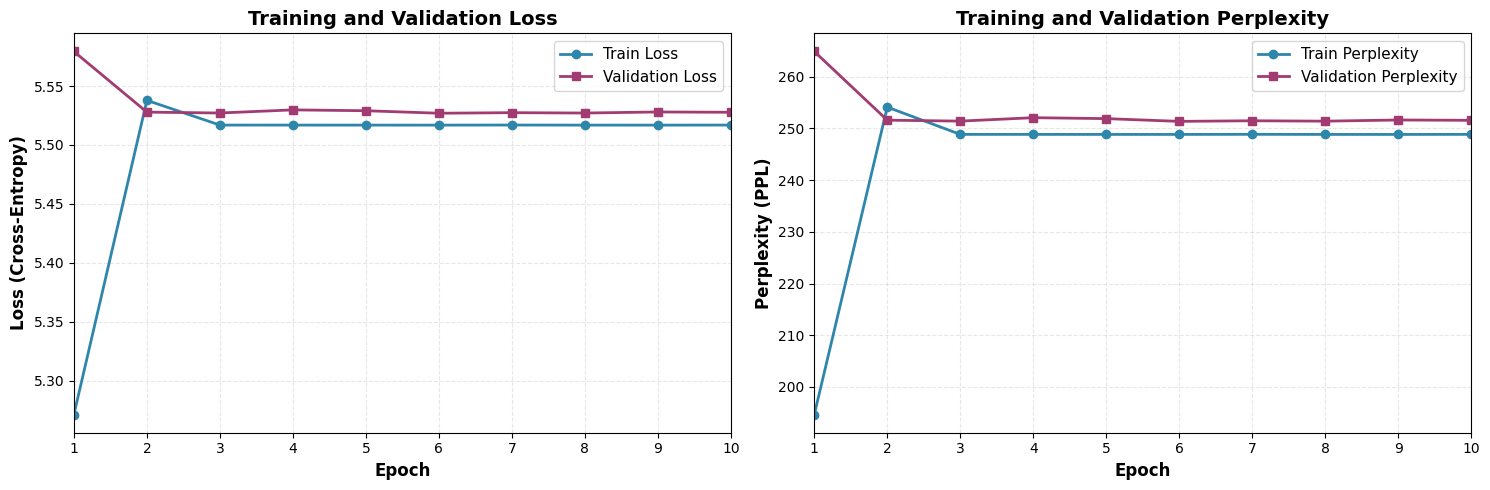


TRAINING SUMMARY
Total epochs trained: 10

Initial Metrics (Epoch 1):
  Train Loss: 5.2713 | Val Loss: 5.5793
  Train PPL: 194.67 | Val PPL: 264.89

Final Metrics (Epoch 10):
  Train Loss: 5.5169 | Val Loss: 5.5277
  Train PPL: 248.86 | Val PPL: 251.58

Best Validation Perplexity: 251.37 (Epoch 6)



In [35]:

# VISUALIZATION 1: Training and Validation Loss & Perplexity Curves

print("\n" + "="*70)
print("TRAINING RESULTS VISUALIZATION")
print("="*70)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss curves
axes[0].plot(range(1, len(train_losses) + 1), train_losses,
             marker='o', linewidth=2, markersize=6, label='Train Loss', color='#2E86AB')
axes[0].plot(range(1, len(val_losses) + 1), val_losses,
             marker='s', linewidth=2, markersize=6, label='Validation Loss', color='#A23B72')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (Cross-Entropy)', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(1, len(train_losses))

# Plot 2: Perplexity curves
train_perplexities = [math.exp(loss) for loss in train_losses]
val_perplexities = [math.exp(loss) for loss in val_losses]

axes[1].plot(range(1, len(train_perplexities) + 1), train_perplexities,
             marker='o', linewidth=2, markersize=6, label='Train Perplexity', color='#2E86AB')
axes[1].plot(range(1, len(val_perplexities) + 1), val_perplexities,
             marker='s', linewidth=2, markersize=6, label='Validation Perplexity', color='#A23B72')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Perplexity (PPL)', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Perplexity', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(1, len(train_perplexities))

plt.tight_layout()
plt.savefig('loss_perplexity_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\n{'='*70}")
print("TRAINING SUMMARY")
print(f"{'='*70}")
print(f"Total epochs trained: {len(train_losses)}")
print(f"\nInitial Metrics (Epoch 1):")
print(f"  Train Loss: {train_losses[0]:.4f} | Val Loss: {val_losses[0]:.4f}")
print(f"  Train PPL: {train_perplexities[0]:.2f} | Val PPL: {val_perplexities[0]:.2f}")
print(f"\nFinal Metrics (Epoch {len(train_losses)}):")
print(f"  Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
print(f"  Train PPL: {train_perplexities[-1]:.2f} | Val PPL: {val_perplexities[-1]:.2f}")
print(f"\nBest Validation Perplexity: {min(val_perplexities):.2f} (Epoch {val_perplexities.index(min(val_perplexities)) + 1})")
print(f"{'='*70}\n")


ATTENTION PATTERN VISUALIZATION

--- Sample 1 ---
Text: ROMEO:
But, soft! what light through yonder window breaks?...


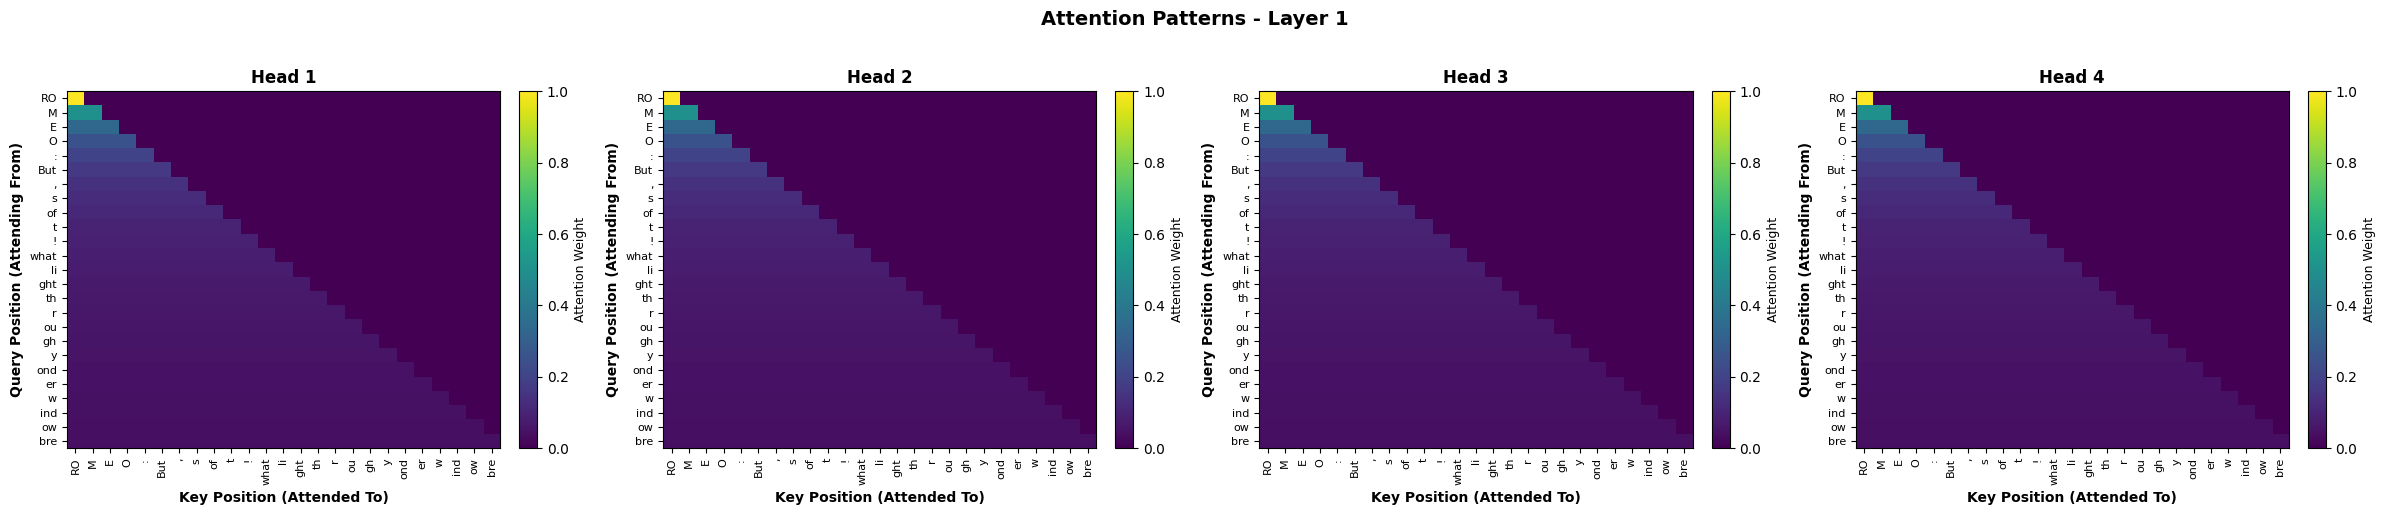

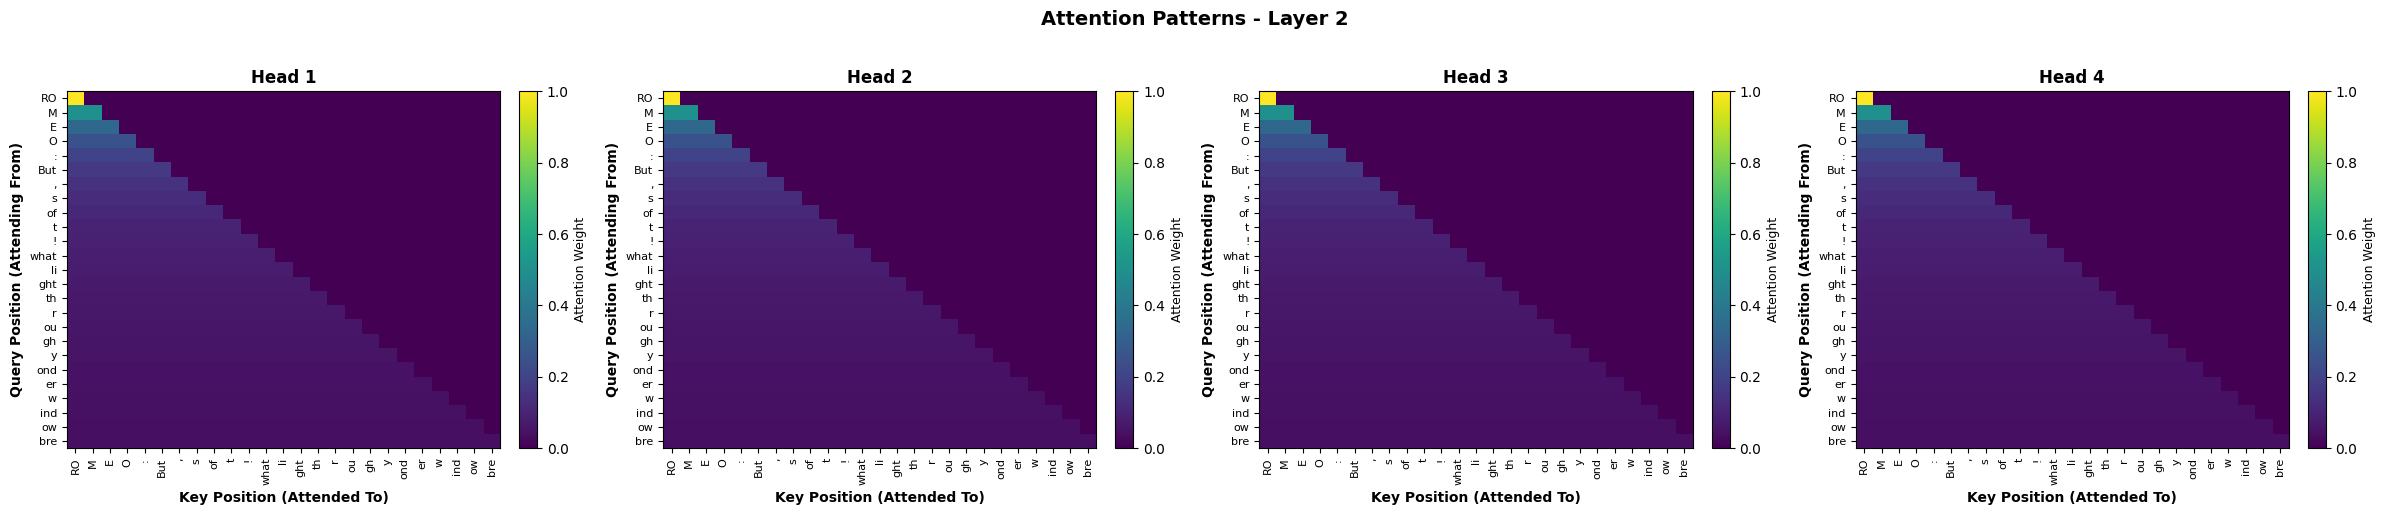


--- Sample 2 ---
Text: To be, or not to be: that is the question:...


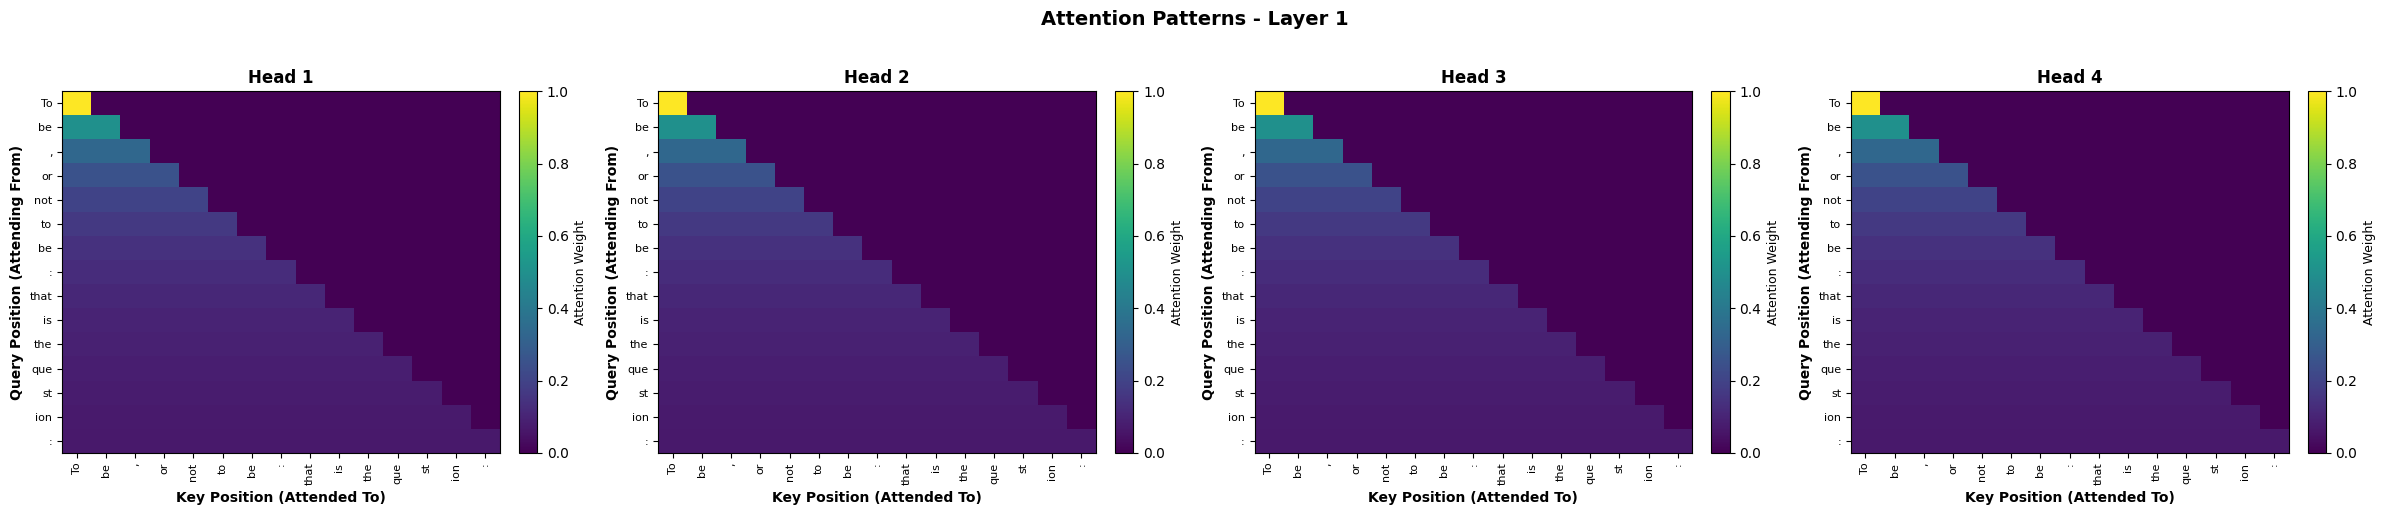

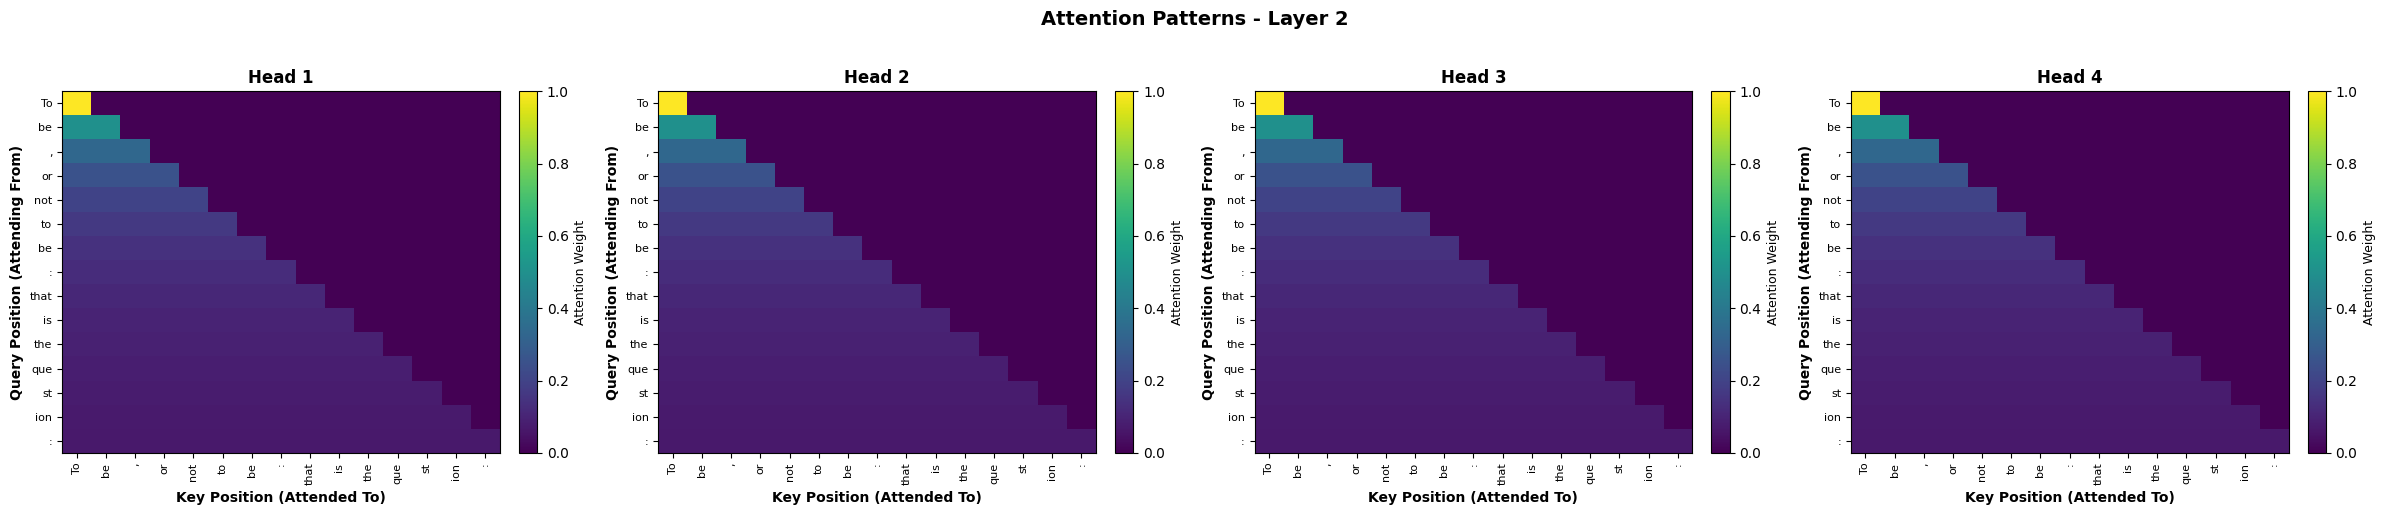


--- Sample 3 ---
Text: First Citizen:
Before we proceed any further, hear me speak....


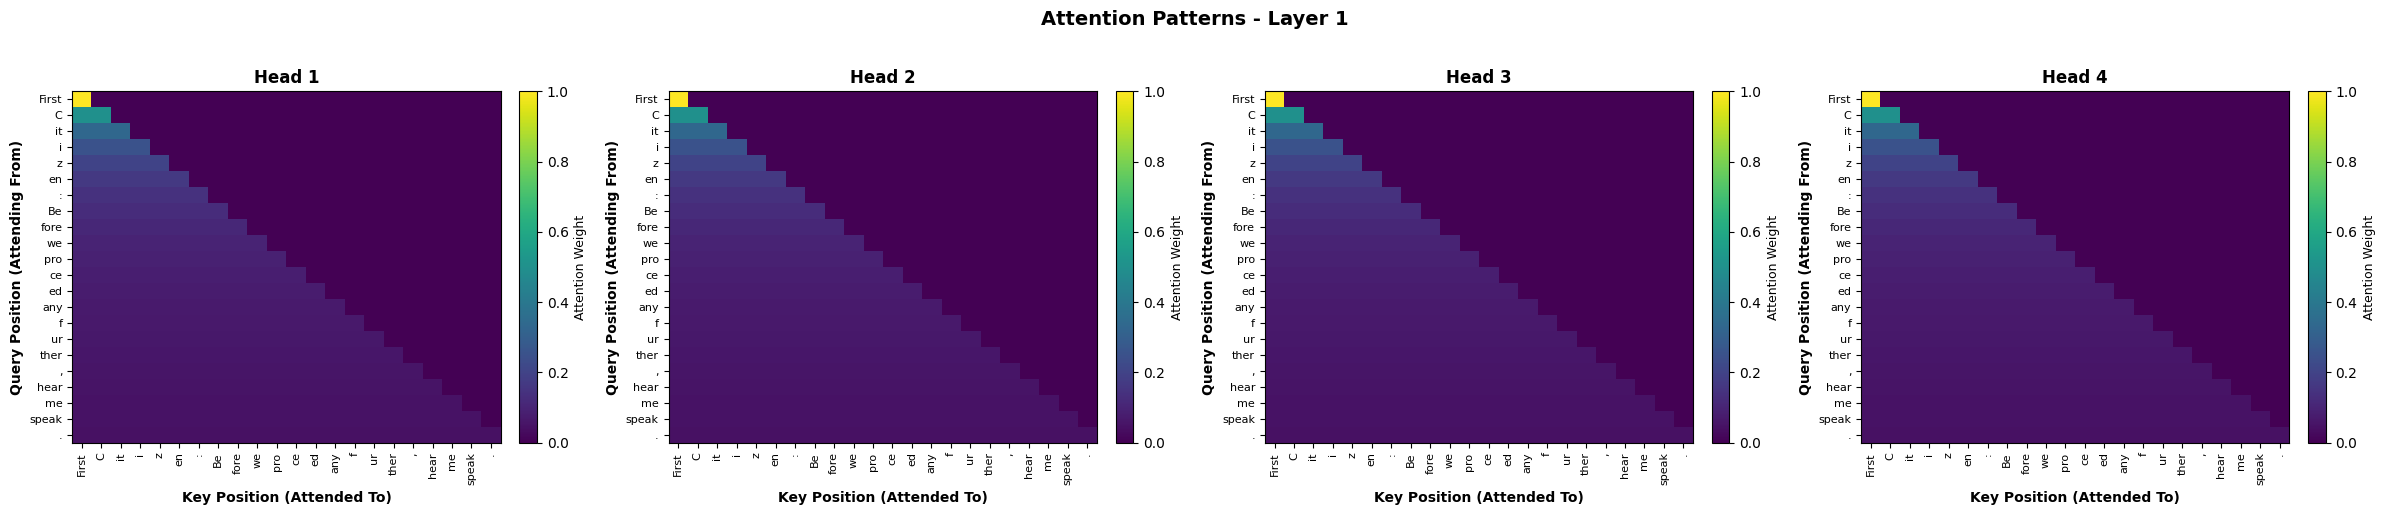

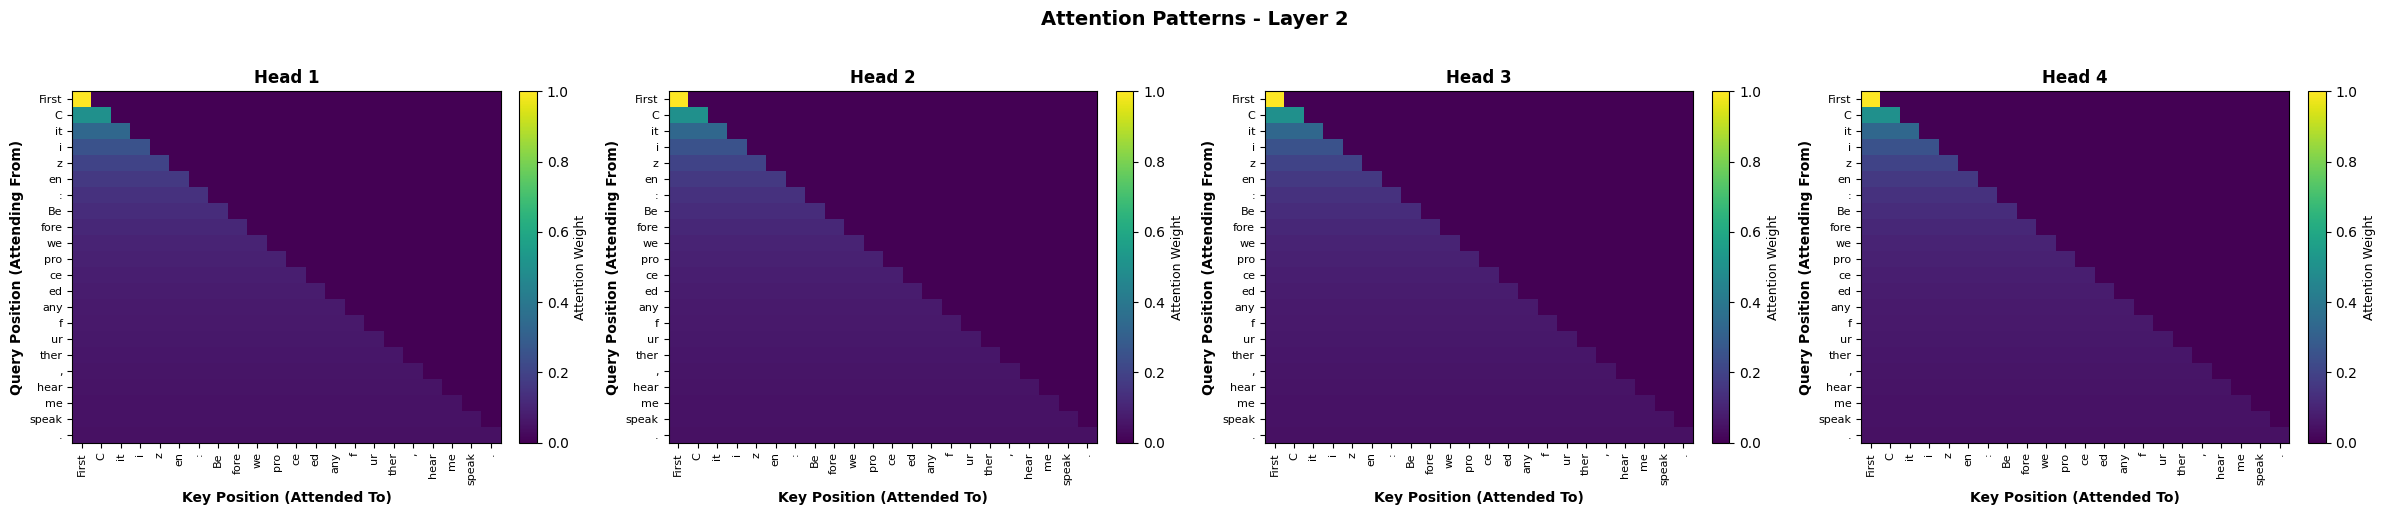

In [36]:

# VISUALIZATION 2: Attention Heatmaps


@torch.no_grad()
def visualize_attention(model, text, layer_idx=0, max_tokens=30):
    """
    Visualize attention patterns for a given text input

    Args:
        model: Trained transformer model
        text: Input text string
        layer_idx: Which transformer layer to visualize (0 or 1)
        max_tokens: Maximum number of tokens to display (for readability)
    """
    model.eval()

    # Encode input text
    tokens = encode(text).unsqueeze(0).to(device)

    # Limit sequence length for visualization clarity
    if tokens.size(1) > max_tokens:
        tokens = tokens[:, :max_tokens]

    # Forward pass to get attention weights
    _ = model(tokens)

    # Get attention weights from specified layer: [batch, n_heads, seq_len, seq_len]
    attention_weights = model.attention_weights[layer_idx][0].cpu().numpy()

    # Decode tokens for labels
    token_texts = [decode([t.item()]) for t in tokens[0]]

    # Create figure with subplots for each attention head
    n_heads = attention_weights.shape[0]
    fig, axes = plt.subplots(1, n_heads, figsize=(6 * n_heads, 5))

    if n_heads == 1:
        axes = [axes]

    for head_idx in range(n_heads):
        ax = axes[head_idx]

        # Plot heatmap
        im = ax.imshow(attention_weights[head_idx], cmap='viridis', aspect='auto', vmin=0, vmax=1)

        # Set ticks and labels
        ax.set_xticks(range(len(token_texts)))
        ax.set_yticks(range(len(token_texts)))
        ax.set_xticklabels(token_texts, rotation=90, fontsize=8)
        ax.set_yticklabels(token_texts, fontsize=8)

        # Labels and title
        ax.set_xlabel('Key Position (Attended To)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Query Position (Attending From)', fontsize=10, fontweight='bold')
        ax.set_title(f'Head {head_idx + 1}', fontsize=12, fontweight='bold')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Attention Weight', fontsize=9)

    plt.suptitle(f'Attention Patterns - Layer {layer_idx + 1}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'attention_layer{layer_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Sample texts to visualize
print("\n" + "="*70)
print("ATTENTION PATTERN VISUALIZATION")
print("="*70)

sample_texts = [
    "ROMEO:\nBut, soft! what light through yonder window breaks?",
    "To be, or not to be: that is the question:",
    "First Citizen:\nBefore we proceed any further, hear me speak."
]

# Visualize attention for each sample
for idx, sample_text in enumerate(sample_texts):
    print(f"\n--- Sample {idx + 1} ---")
    print(f"Text: {sample_text[:60]}...")

    # Visualize both layers
    for layer in range(n_layers):
        visualize_attention(model, sample_text, layer_idx=layer, max_tokens=25)

In [37]:

# VISUALIZATION 3: Text Generation Samples


@torch.no_grad()
def generate_text(model, prompt, max_length=100, temperature=1.0, top_k=None):
    """
    Generate text using the trained transformer model

    Args:
        model: Trained transformer model
        prompt: Starting text string
        max_length: Number of tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: If specified, only sample from top k most likely tokens

    Returns:
        Generated text string
    """
    model.eval()

    # Encode the prompt
    tokens = encode(prompt).unsqueeze(0).to(device)

    # Generate tokens one at a time
    for _ in range(max_length):
        # Get model predictions (use only last seq_length tokens if sequence is too long)
        input_tokens = tokens if tokens.size(1) <= seq_length else tokens[:, -seq_length:]
        outputs = model(input_tokens)

        # Get logits for the last token
        logits = outputs[0, -1, :] / temperature

        # Apply top-k filtering if specified
        if top_k is not None:
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            logits = torch.full_like(logits, float('-inf'))
            logits[top_k_indices] = top_k_logits

        # Sample from the distribution
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

    # Decode and return
    return decode(tokens[0].tolist())


print("\n" + "="*70)
print("TEXT GENERATION SAMPLES")
print("="*70)

# Define prompts
prompts = [
    "ROMEO:",
    "To be or not to be",
    "First Citizen:",
    "JULIET:",
    "What light through"
]

# Generate with different temperatures
temperatures = [0.5, 0.8, 1.0]

for temp in temperatures:
    print(f"\n{'='*70}")
    print(f"Temperature: {temp}")
    print(f"{'='*70}")

    for prompt in prompts:
        print(f"\n--- Prompt: '{prompt}' ---")
        generated = generate_text(model, prompt, max_length=60, temperature=temp, top_k=50)

        # Print prompt in bold and generation normally
        print(f"Generated text:")
        print(generated)
        print("-" * 50)


TEXT GENERATION SAMPLES

Temperature: 0.5

--- Prompt: 'ROMEO:' ---
Generated text:
RO M E O : , the A , n g I , ar , , c ar er I e s , I re I , the s , m : st the y s s , , : to , ; , . , ' p t A ' l a , , , en : . , d ; : : s
--------------------------------------------------

--- Prompt: 'To be or not to be' ---
Generated text:
To be or not to be , b it , d y d st , en : , c , b , s , ; , , ing t ! s . of s , is : . w , , , the to , re p c s . a s s , , m m : , ! , : : i or ,
--------------------------------------------------

--- Prompt: 'First Citizen:' ---
Generated text:
First C it i z en : I , . of s . : d . , g p s , s l : , : , , , e e e for ing I , the . , s s er : s e , s be p my b p , en the ' , , s s a s , , of l s
--------------------------------------------------

--- Prompt: 'JULIET:' ---
Generated text:
J UL I ET : , , b , s , e e , , a t s s ' . c in : : , , a , th the . l , , the c d I ; to s , , en the m , c er l . s s my I , p w , g , I s or
---------------------


FINAL PERPLEXITY EVALUATION


Computing Perplexity: 100%|██████████| 1400/1400 [00:03<00:00, 353.29it/s]



----------------------- VALIDATION SET METRICS -----------------------
Average Loss:           5.5277
Perplexity (PPL):       251.56
Standard Deviation:     0.1237
Min Batch Loss:         5.0433
Max Batch Loss:         5.9012
----------------------------------------------------------------------

Computing training set perplexity (sample)...


Computing Perplexity: 100%|██████████| 157/157 [00:00<00:00, 348.74it/s]



------------------- TRAINING SET METRICS (Sample) --------------------
Average Loss:           0.1539
Perplexity (PPL):       1.17
Standard Deviation:     0.0190
----------------------------------------------------------------------


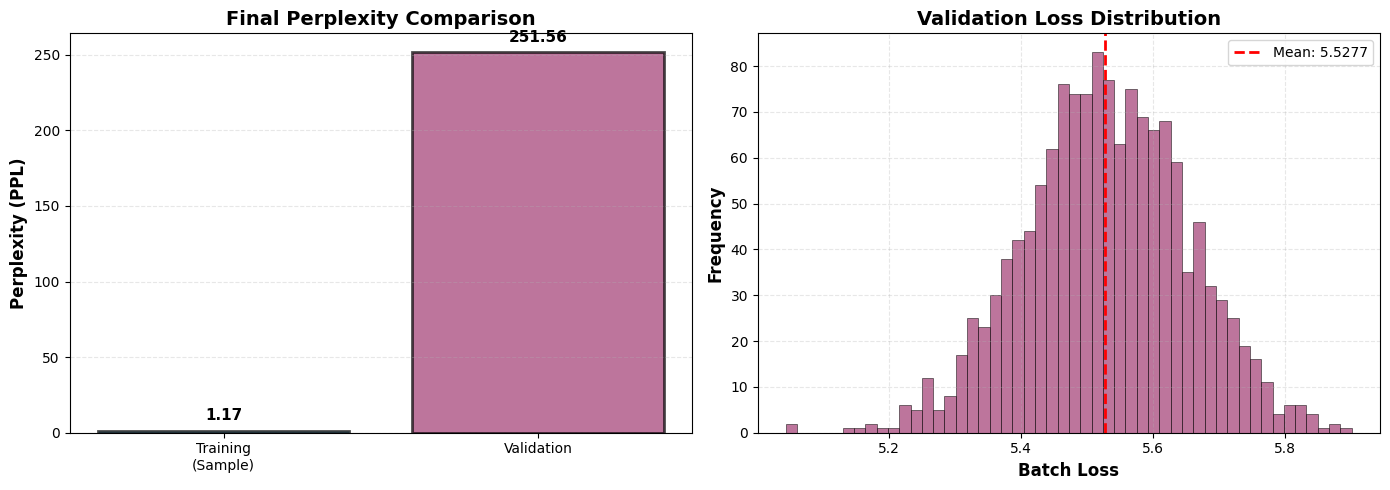


--------------------------- INTERPRETATION ---------------------------

The model achieved a validation perplexity of 251.56.

Perplexity Interpretation:
- Lower perplexity = better model (more confident predictions)
- Perplexity of 251.56 means the model is roughly 252-ways uncertain
  about the next token on average
- Gap between train (1.17) and val (251.56) PPL:
  250.40
   Significant overfitting detected

Typical Perplexity Ranges for Character-Level Language Models:
- Excellent: < 10
- Good: 10-30
- Acceptable: 30-100
- Poor: > 100

Current Model Status: Needs improvement



In [38]:

# FINAL EVALUATION: Comprehensive Perplexity Report


@torch.no_grad()
def compute_perplexity(model, dataloader, criterion):
    """
    Compute perplexity on a dataset with detailed statistics
    """
    model.eval()
    total_loss = 0
    total_tokens = 0
    batch_losses = []

    for inputs, targets in tqdm(dataloader, desc="Computing Perplexity"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        batch_size = inputs.size(0)
        seq_len = inputs.size(1)

        total_loss += loss.item() * batch_size
        total_tokens += batch_size * seq_len
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    perplexity = math.exp(avg_loss)

    return {
        'loss': avg_loss,
        'perplexity': perplexity,
        'batch_losses': batch_losses,
        'std_loss': np.std(batch_losses),
        'min_loss': min(batch_losses),
        'max_loss': max(batch_losses)
    }


print("\n" + "="*70)
print("FINAL PERPLEXITY EVALUATION")
print("="*70)

# Compute detailed statistics for validation set
val_stats = compute_perplexity(model, val_loader, criterion)

print(f"\n{' VALIDATION SET METRICS ':-^70}")
print(f"Average Loss:           {val_stats['loss']:.4f}")
print(f"Perplexity (PPL):       {val_stats['perplexity']:.2f}")
print(f"Standard Deviation:     {val_stats['std_loss']:.4f}")
print(f"Min Batch Loss:         {val_stats['min_loss']:.4f}")
print(f"Max Batch Loss:         {val_stats['max_loss']:.4f}")
print("-" * 70)

# Compute statistics for training set (on a sample for efficiency)
print("\nComputing training set perplexity (sample)...")
train_sample_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                  sampler=torch.utils.data.RandomSampler(train_dataset,
                                                                          num_samples=min(10000, len(train_dataset))))
train_stats = compute_perplexity(model, train_sample_loader, criterion)

print(f"\n{' TRAINING SET METRICS (Sample) ':-^70}")
print(f"Average Loss:           {train_stats['loss']:.4f}")
print(f"Perplexity (PPL):       {train_stats['perplexity']:.2f}")
print(f"Standard Deviation:     {train_stats['std_loss']:.4f}")
print("-" * 70)

# Create a comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Perplexity comparison
datasets = ['Training\n(Sample)', 'Validation']
perplexities = [train_stats['perplexity'], val_stats['perplexity']]
colors = ['#2E86AB', '#A23B72']

axes[0].bar(datasets, perplexities, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Perplexity (PPL)', fontsize=12, fontweight='bold')
axes[0].set_title('Final Perplexity Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels on bars
for i, (dataset, ppl) in enumerate(zip(datasets, perplexities)):
    axes[0].text(i, ppl + max(perplexities) * 0.02, f'{ppl:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Distribution of batch losses
axes[1].hist(val_stats['batch_losses'], bins=50, color='#A23B72', alpha=0.7,
            edgecolor='black', linewidth=0.5)
axes[1].axvline(val_stats['loss'], color='red', linestyle='--', linewidth=2,
               label=f'Mean: {val_stats["loss"]:.4f}')
axes[1].set_xlabel('Batch Loss', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Loss Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('final_perplexity_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary interpretation
print(f"\n{' INTERPRETATION ':-^70}")
print(f"""
The model achieved a validation perplexity of {val_stats['perplexity']:.2f}.

Perplexity Interpretation:
- Lower perplexity = better model (more confident predictions)
- Perplexity of {val_stats['perplexity']:.2f} means the model is roughly {val_stats['perplexity']:.0f}-ways uncertain
  about the next token on average
- Gap between train ({train_stats['perplexity']:.2f}) and val ({val_stats['perplexity']:.2f}) PPL:
  {abs(train_stats['perplexity'] - val_stats['perplexity']):.2f}
  {" Significant overfitting detected" if val_stats['perplexity'] - train_stats['perplexity'] > 10 else "✓ Reasonable generalization"}

Typical Perplexity Ranges for Character-Level Language Models:
- Excellent: < 10
- Good: 10-30
- Acceptable: 30-100
- Poor: > 100

Current Model Status: {"Needs improvement" if val_stats['perplexity'] > 30 else "Good performance"}
""")
print("=" * 70)